# CNN2ID基于CNN的网络攻击检测

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import logging
from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import MLP
from utils import (
    dataset,
    test,
    train,
    train_copy,
    utils,
    visualisation
)

/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

check GPU is available?

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

In [5]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=True)

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 64

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  140000
# instances in validation set:  485146
# instances in testing set:  485145


In [6]:
#Create model
class CNN2ID(nn.Module):
    def __init__(self):
        super(CNN2ID, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels = 64, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.maxpool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.maxpool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*64, 64)#应该是这里的问题
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 7)#64, 3
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.maxpool1(x)
        
        x = self.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool2(x)
        
        x = self.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.maxpool3(x)
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        
        return x

In [7]:
model = CNN2ID()
# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.02
optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Epochs
num_epochs = 5

In [21]:
from tqdm import tqdm
import logging
def train1(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    #logging.basicConfig(level=logging.INFO)
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for inputs, labels in tqdm(train_loader):
            #对input进行变换
            inputs = inputs.reshape(len(inputs), 1, inputs.shape[1])
            labels = labels.view(-1)
            inputs, labels = inputs.to(device), labels.to(device)#放入device cuda中
            
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_loss += loss.cpu().item()
            train_loss += loss.item()
            train_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #train_output_pred += outputs.argmax(1).cpu().tolist()
            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()
        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader):
                inputs = inputs.reshape(len(inputs), 1, inputs.shape[1])#对inputs进行变换
                labels = labels.view(-1)
                inputs, labels = inputs.to(device), labels.to(device)
                #labels = labels.squeeze(1)
                
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

In [17]:
#得到X_train, X_val, X_test
X_train = train_data.features
X_val = val_data.features
X_test = test_data.features

y_train = train_data.labels
y_val = val_data.labels
y_test = test_data.labels

y_test = y_test.squeeze()
y_val = y_val.squeeze()

#reshape the data for CNN pytorch
X_train = X_train.to_numpy().reshape(len(X_train), 1, X_train.shape[1])
X_val = X_val.to_numpy().reshape(len(X_val), 1, X_val.shape[1])
X_test = X_test.to_numpy().reshape(len(X_test), 1, X_test.shape[1])
X_train.shape, X_test.shape

#训练函数
def train2(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        num_samples = X_train.shape[0]

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for batch in tqdm(range(num_samples // batch_size)):
            start_index = batch * batch_size
            end_index = (batch + 1) * batch_size
            inputs = torch.tensor(X_train[start_index:end_index], dtype=torch.float32)
            labels = torch.tensor(y_train.values[start_index:end_index], dtype=torch.long)

            optimizer.zero_grad()  # 梯度清零

            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            _, predicted = torch.max(outputs, 1)
            #acc = torch.sum(preds ==labels.data) / labels.size(0)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            train_loss += loss.item()
            train_steps += 1

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()

        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for batch in tqdm(range(X_test.shape[0] // batch_size)):
                start_index = batch * batch_size
                end_index = (batch + 1) * batch_size
                inputs = torch.tensor(X_test[start_index:end_index], dtype=torch.float32)
                labels = torch.tensor(y_test.values[start_index:end_index], dtype=torch.long)

                outputs = model(inputs)  # 前向传播
                loss = criterion(outputs, labels)  # 计算损失
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs, 1)  # 预测结果
                #acc = torch.sum(preds == labels.data) / labels.size(0)  # 计算准确率
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

### Train it

In [18]:
device = 'cpu'
history = train2(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-03-27 18:56:11,288 | 3075746052.py:62 | Epoch 1/5:


100%|██████████| 7580/7580 [00:20<00:00, 367.57it/s]

INFO 2024-03-27 18:56:53,884 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:56:53,888 | 3075746052.py:62 | Epoch 2/5:



100%|██████████| 7580/7580 [00:20<00:00, 369.99it/s]

INFO 2024-03-27 18:57:36,118 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:57:36,119 | 3075746052.py:62 | Epoch 3/5:



100%|██████████| 7580/7580 [00:20<00:00, 369.00it/s]

INFO 2024-03-27 18:58:18,374 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:58:18,378 | 3075746052.py:62 | Epoch 4/5:



100%|██████████| 7580/7580 [00:20<00:00, 375.77it/s]

INFO 2024-03-27 18:58:59,864 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:58:59,866 | 3075746052.py:62 | Epoch 5/5:



100%|██████████| 7580/7580 [00:20<00:00, 364.94it/s]

INFO 2024-03-27 18:59:42,638 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:59:42,640 | 3075746052.py:131 | Finished Training


In [22]:
device = 'cpu'
history = train1(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-03-27 19:34:18,661 | 2040591022.py:44 | Epoch 1/5:


100%|██████████| 7581/7581 [01:53<00:00, 66.98it/s]

INFO 2024-03-27 19:36:49,718 | 2040591022.py:110 | loss: 2.022526291486768 - acc: 0.14285714285714285 - val_loss: 1.3263255999626389 - val_acc: 0.8391020435085521
INFO 2024-03-27 19:36:49,720 | 2040591022.py:44 | Epoch 2/5:



100%|██████████| 7581/7581 [01:52<00:00, 67.13it/s]

INFO 2024-03-27 19:39:20,144 | 2040591022.py:110 | loss: 2.022561997447633 - acc: 0.14285714285714285 - val_loss: 1.3263165622442477 - val_acc: 0.8391020435085521
INFO 2024-03-27 19:39:20,146 | 2040591022.py:44 | Epoch 3/5:



100%|██████████| 7581/7581 [01:52<00:00, 67.44it/s]

INFO 2024-03-27 19:41:50,218 | 2040591022.py:110 | loss: 2.022554856331736 - acc: 0.14285714285714285 - val_loss: 1.3263195753883772 - val_acc: 0.8391020435085521
INFO 2024-03-27 19:41:50,219 | 2040591022.py:44 | Epoch 4/5:



100%|██████████| 7581/7581 [01:53<00:00, 66.62it/s]

INFO 2024-03-27 19:44:22,126 | 2040591022.py:110 | loss: 2.0225477148344573 - acc: 0.14285714285714285 - val_loss: 1.3263195748222862 - val_acc: 0.8391020435085521
INFO 2024-03-27 19:44:22,128 | 2040591022.py:44 | Epoch 5/5:



100%|██████████| 7581/7581 [01:55<00:00, 65.76it/s]

INFO 2024-03-27 19:46:55,506 | 2040591022.py:110 | loss: 2.0225691388904288 - acc: 0.14285714285714285 - val_loss: 1.3263075262084043 - val_acc: 0.8391020435085521
INFO 2024-03-27 19:46:55,507 | 2040591022.py:112 | Finished Training


### Plot loss vs iterations

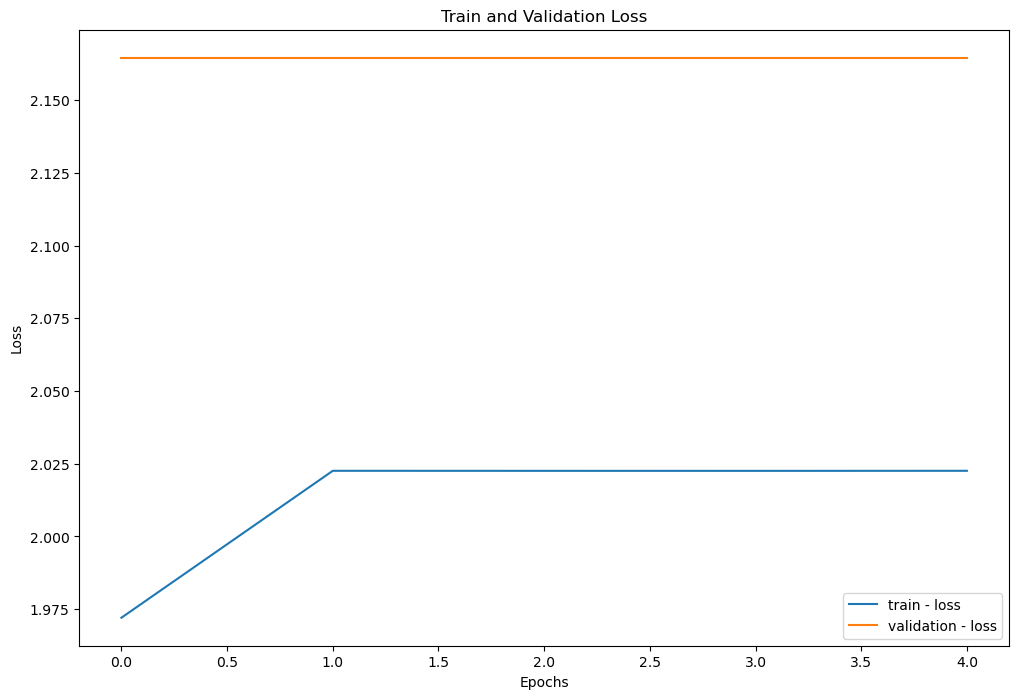

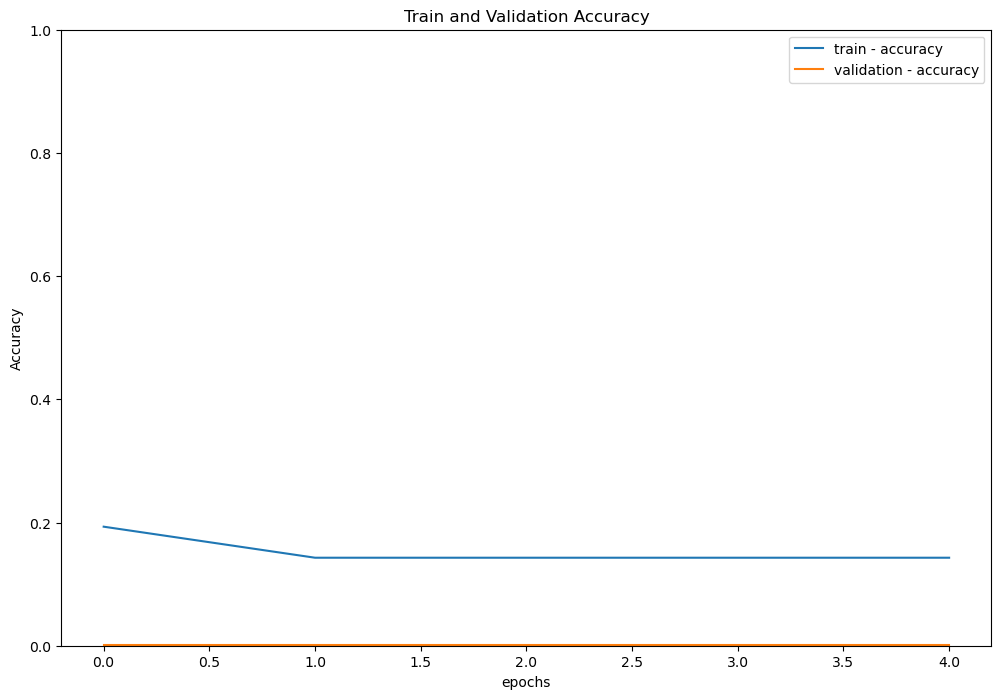

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

../../utils/visualisation.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_train_confusion_matrix.pdf'

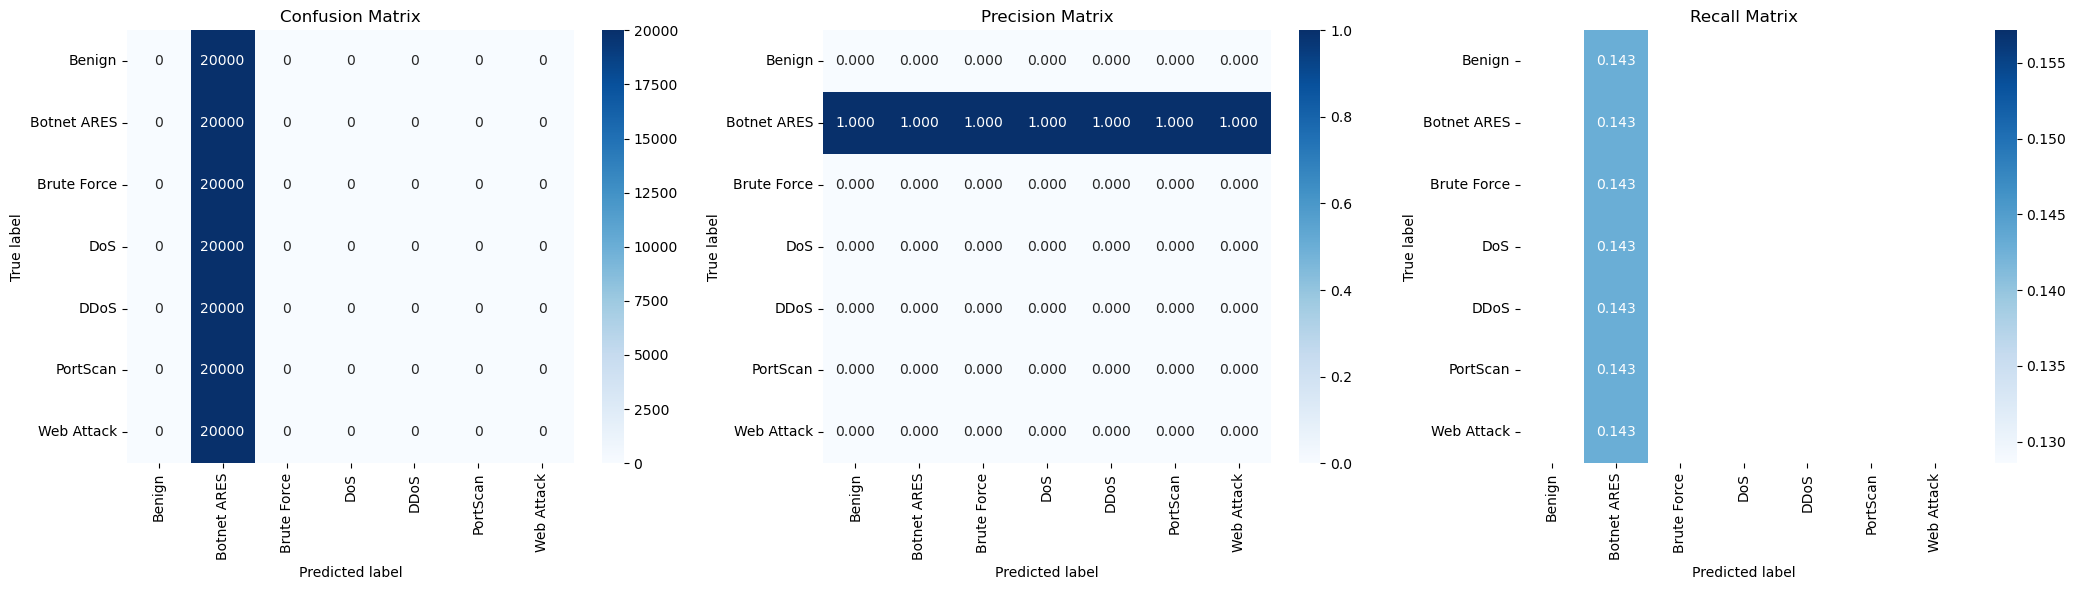

In [11]:
#labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS', 'DDoS', 'PortScan', 'Web Attack']
visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_train_confusion_matrix.pdf")